# Introduction 

This notebook calculates the heart rate zones using the running data I extracted from my Garmin Vivoactive 4 device. 

The main problems this notebook aims to address are:

1. Find a more representitive metric than running speed to measure body exertion. 
2. Filtering and filling in null values
3. Scaling the metrics of interest
4. Calculating the running zones
5. Does the result make sense?


Import libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import TheilSenRegressor
pd.options.mode.chained_assignment = None

# 0. Data inspection and cleaning

In [2]:
all_runs = pd.read_csv('all_runs.csv', header=0)
all_runs.head()

,Unnamed: 0,latitude,longitude,lap,distance,enhanced_speed,enhanced_altitude,altitude,timestamp,heart_rate,cadence,speed,AltitudeMeters,date
0,2791,NaN,NaN,1,2.83,2.510,50.0,NaN,2020-08-02 15:51:31+00:00,100,80.0,NaN,NaN,2020-08-02
1,2792,NaN,NaN,1,5.19,2.071,50.0,NaN,2020-08-02 15:51:32+00:00,101,80.0,NaN,NaN,2020-08-02
2,2793,NaN,NaN,1,11.72,2.361,28.2,NaN,2020-08-02 15:51:35+00:00,103,80.0,NaN,NaN,2020-08-02
3,2794,NaN,NaN,1,14.12,2.417,28.4,NaN,2020-08-02 15:51:36+00:00,109,80.0,NaN,NaN,2020-08-02
4,2795,NaN,NaN,1,16.88,2.417,28.2,NaN,2020-08-02 15:51:37+00:00,110,80.0,NaN,NaN,2020-08-02


Only select the columns we'll be using

In [3]:
all_runs = all_runs[['date','timestamp','distance','enhanced_speed','enhanced_altitude','heart_rate']]

Making sure that the column types are correct

In [4]:
all_runs['date'] = pd.to_datetime(all_runs['date'])
all_runs['timestamp'] = pd.to_datetime(all_runs['timestamp'])

Basic overview of data

In [5]:
n = all_runs['date'].nunique()
n_min = all_runs['date'].min()
n_max = all_runs['date'].max()
print(f'There are {n} runs in total. Ranging from {n_min} to {n_max}')

There are 128 runs in total. Ranging from 2020-05-26 00:00:00 to 2021-06-19 00:00:00


In [6]:
# We need to do a rolling mean of the altitude as it is pretty noisy
all_runs['alt'] = all_runs['enhanced_altitude'].rolling(50,min_periods=1).mean()

# 1. Calculating running power 

We know that energy consumption when running is largely comprised of:

- Energy used overcome wind and contract friction against the ground at constant speed
- Energy used to run uphill
- Energy used to accelerate


We need to consider all three elements togather when calculating running power. 

Since we do not have wind speed at the time of the runs, we can only assume that it does not change the running power significantly. This assumption is relatively safe since I almost never run in the wind. 

Energy consumption at any given time, running power, can therefore be calculated as:

`P = (m)(dv_x)(dx) + (m)(g + dv_y)(dy) + 0.5(rho)(cd)(m)(v)^2`

where:

`P = power at given instance`

`m = mass of the body`

`dv_x = acceleration in the x horizontal direction, rolling difference of speed`

`dx = displacement, rolling mean difference of distance`

`g = acceleration due to gravity`

`dv_y = acceleration in the y direction, rolling mean difference of altitude divided by rolling mean difference of time squred`

`v = speed`

`rho = density of air, 1.225`

`cd = drag coefficient of human body, 1`


In [7]:
def calc_power(df,  rho, cd):
    '''
    Calculates running power per mass
    
    Params:
    -------
    df [pandas.DataFrame]: input dataframe
    rho [float]: density of air in m^3/kg
    cd [float]: drag coefficient
    
    Returns:
    df [pandas.DataFrame]: output dataframe
    '''
    g = 9.81
    columns = list(df.columns)
    columns_out = columns[:]
    df.sort_values(['date', 'timestamp'], inplace=True)
    df['time_int'] = df['timestamp'].astype(int)/(10**9)
    df['dt'] = np.where(df['date'] == df['date'].shift(1), df['time_int'].diff(), 0)
    
    df['dv_x'] = np.where(df['date'] == df['date'].shift(1), df['enhanced_speed'].diff(), 0)/df['dt']
    df['dv_x'] = df['dv_x'].rolling(50,min_periods=1).mean()
    df['dx'] = np.where(df['date'] == df['date'].shift(1), df['distance'].diff(), 0)
    
    df['dv_y'] = np.where(df['date'] == df['date'].shift(1), df['alt'].diff(), 0)/(df['dt']**2)
    df['dv_y'] = df['dv_y'].rolling(50,min_periods=1).mean()
    
    df['dy'] = np.where(df['date'] == df['date'].shift(1), df['alt'].diff(), 0)
    
    df['power'] = df['dv_x']*df['dx']+ (g+df['dv_y'])*df['dy']+0.5*rho*cd*df['enhanced_speed']**2
    columns_out.append('power')
    columns_out.append('dt')
    return df[columns_out]

In [8]:
power_df = calc_power(all_runs, 1.225, 0.8)

## 1.1 Showing example with plots

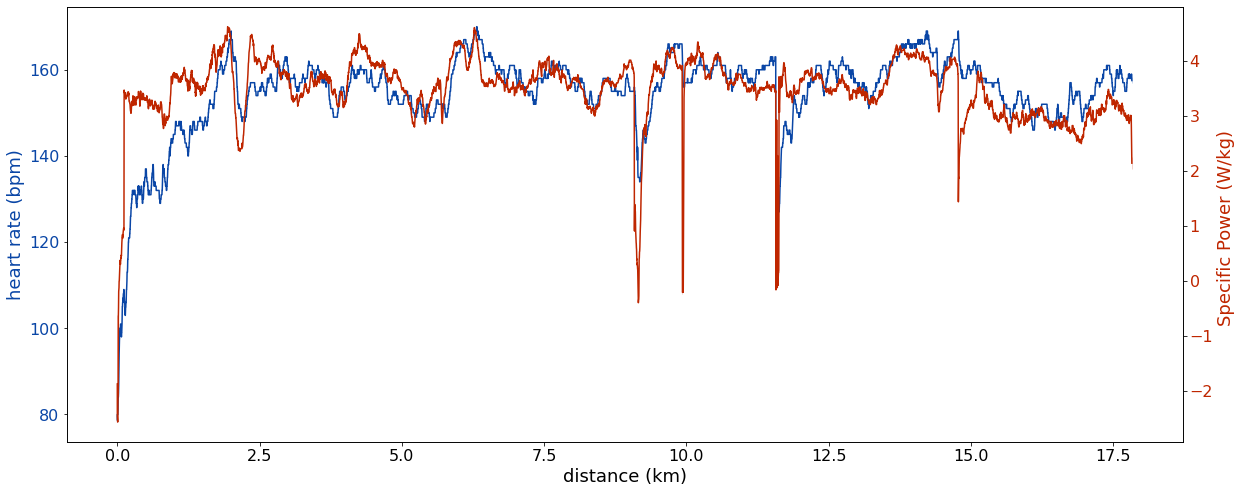

In [9]:
plot_df = power_df[(power_df['date']=='2021-05-30')]
fig, ax1 = plt.subplots(figsize= (20,8))

color = '#0a46a6'
ax1.set_xlabel('distance (km)', fontsize = 18)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
ax1.set_ylabel('heart rate (bpm)', color=color,  fontsize = 18)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
sns.lineplot(x = plot_df['distance']/1000 , y = 'heart_rate', color=color, ax = ax1, data = plot_df)
ax2 = ax1.twinx()

color = '#bf2600'
sns.lineplot(x = plot_df['distance']/1000, y = 'power', ax = ax2,color=color, data = plot_df)

ax2.set_ylabel('Specific Power (W/kg) ', color=color,  fontsize = 18)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)




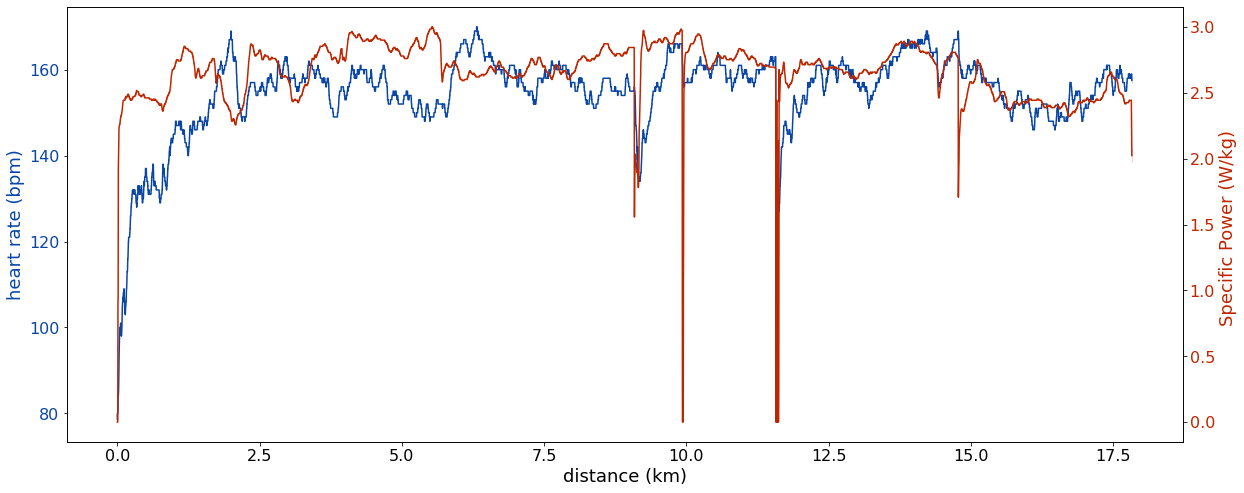

In [26]:
plot_df = power_df[(power_df['date']=='2021-05-30')]
fig, ax1 = plt.subplots(figsize= (20,8))

color = '#0a46a6'
ax1.set_xlabel('distance (km)', fontsize = 18)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
ax1.set_ylabel('heart rate (bpm)', color=color,  fontsize = 18)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
sns.lineplot(x = plot_df['distance']/1000 , y = 'heart_rate', color=color, ax = ax1, data = plot_df)
ax2 = ax1.twinx()

color = '#bf2600'
sns.lineplot(x = plot_df['distance']/1000, y = 'enhanced_speed', ax = ax2,color=color, data = plot_df)

ax2.set_ylabel('Specific Power (W/kg) ', color=color,  fontsize = 18)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)




The example above compares how closely power (top, red) and speed (bottom, red) matched against the heart rate (red). We see that heart rate and power matched better than heart rate and speed.
As expected, the heart rate was relativly lower than the given power output at the beginning of the run (up to 2.5km). From 2.5 km to about 15 km, heart rate and power matched well and changed consistently. After 15 km, heart rate appeared to have increased faster than power, possibly due to a build-up of lactic acid and dehydration. My hypothesis is that the time it takes to reach this point is highly dependent on the heart rate zone.

# 2. Filtering extreme values and filling in nulls

## 2.1 Calculate the rolling mean difference and filtering limits

In [10]:

power_df.sort_values(['date', 'timestamp'], inplace=True)
power_df.set_index('timestamp', inplace=True)

power_df['power_mean']= np.where(power_df['date'] == power_df['date'].shift(1),  power_df['power'].rolling('5s', min_periods =1).mean(), 0)
power_df['rolling_diff'] = np.where(power_df['date'] == power_df['date'].shift(1), power_df['power_mean'].diff()/power_df['power_mean'].shift(1), 0)
power_df.replace([np.inf, -np.inf], np.nan, inplace=True)

power_df = power_df.dropna(subset=['rolling_diff'])

perc_95 = power_df['rolling_diff'].quantile(0.95)
perc_5 = power_df['rolling_diff'].quantile(0.05)
print('The 95th percentile for rolling difference in power is {}'.format(perc_95))
print('The 5th percentile for rolling difference in power is {}'.format(perc_5))

The 95th percentile for rolling difference in power is 0.04727782464678728
The 5th percentile for rolling difference in power is -0.05163099107761946


## 2.2 Apply filter

In [11]:
power_df['filtered'] = power_df.apply(lambda row: row['power'] if  (row['rolling_diff']<=perc_95) & (row['rolling_diff']>=perc_5) & (row['power']>0) else None , axis=1)

## 2.3 Forward fill filtered values

In [12]:
power_df['filled'] = power_df['filtered'].fillna(method="ffill")

## 2.4 Illustrate the filtering method

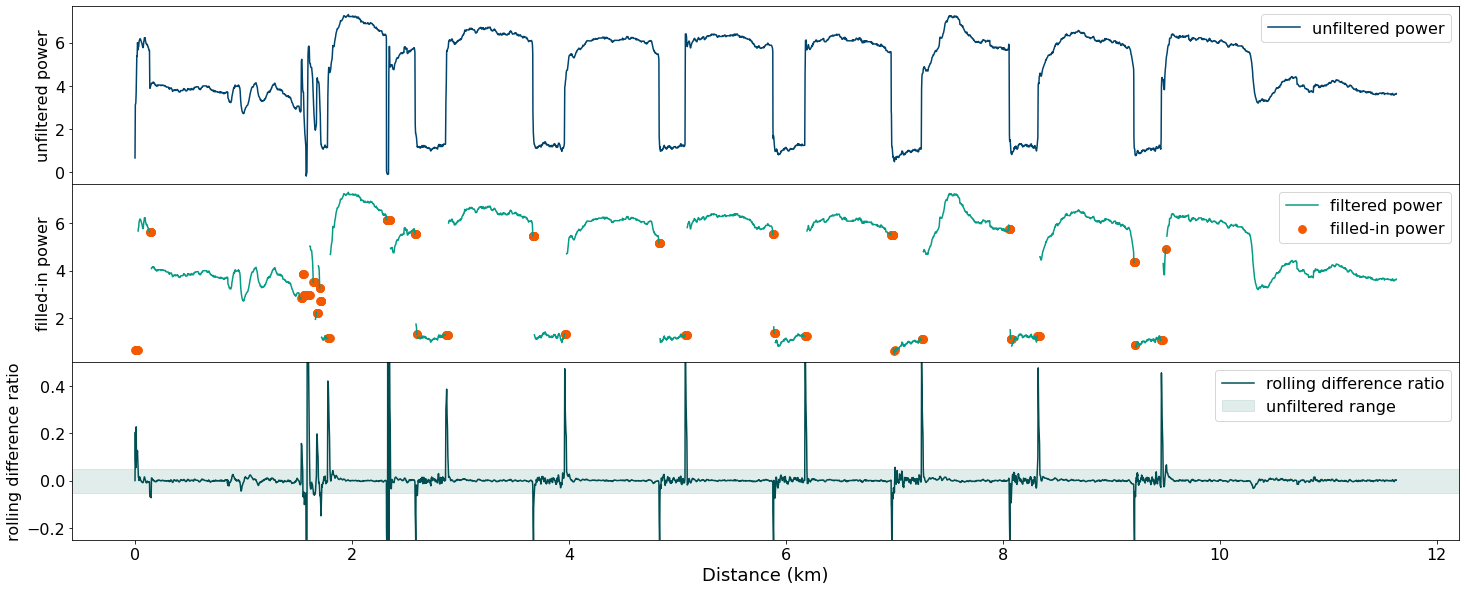

In [13]:
plot_df = power_df[ (power_df['date']=='2021-06-13')  ]
filtered = plot_df[plot_df['filtered'].isna()]

fig,ax = plt.subplots(3, 1,figsize=(20, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].plot(plot_df['distance']/1000, plot_df['power'],  color='#00446e', label='unfiltered power')
ax[1].plot(plot_df['distance']/1000, plot_df['filtered'], color = '#059c85', label='filtered power')
ax[1].scatter(filtered['distance']/1000, filtered['filled'], s=60, color = '#f25900', label='filled-in power')
ax[2].plot(plot_df['distance']/1000, plot_df['rolling_diff'],  color = '#004e52',label='rolling difference ratio')
ax[2].axhspan(perc_5,perc_95, alpha=0.3, color = '#99c4ba', label='unfiltered range')


ax[0].legend(fontsize = 16)
ax[0].set_xlabel('')
ax[0].set_ylabel('unfiltered power',fontsize=16)
ax[0].set_xticklabels([])
ax[0].tick_params(axis='y',labelsize=16)

ax[1].legend(fontsize = 16)
ax[1].set_ylabel('filled-in power',fontsize=16)
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
ax[1].tick_params(axis='y',labelsize=16)

ax[2].legend(fontsize = 16)
ax[2].set_xlabel('Distance (km)', fontsize = 18)
ax[2].set_ylim(-0.25,0.5)
ax[2].set_ylabel('rolling difference ratio',fontsize=16)
ax[2].tick_params(axis='x',labelsize=16)
ax[2].tick_params(axis='y',labelsize=16)

As shown above, the filtering method effectively identified the spikes in data (graph 3) and removed them (grpah 2). The fill-in values in grpah 2 also makes sense.

# 3 Scaling values

In [14]:
power_df.rename(columns = {'power':'power_raw', 'filled':'power'}, inplace=True,  errors="raise")

<AxesSubplot:>

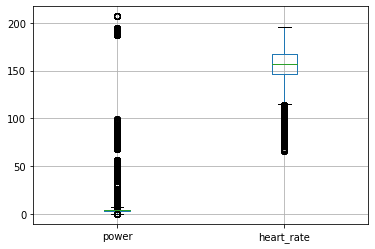

In [15]:
power_df[['power','heart_rate']].boxplot()

The box and whisker plot above clear indicates that the `power` metric is heavilly affacted by outlier, even after filtering. We therefore and not simply use the min and max values to scale it. The 99th percentile was selected as the maximum for the `power` metric. 

In [16]:
max_heart_rate = power_df['heart_rate'].max()
min_heart_rate = 100

max_power = power_df['power'].quantile(0.99)
min_power = 0

def min_max_scaling(df, column, min, max):
    '''
    min-max scaling with 
    '''
    return [ (x-min) /(max-min) if (x <= max) and (x>-min) else 1  if x>=max else 0 for x in df[column].values ]


power_df['scaled_heart_rate'] = min_max_scaling(power_df, 'heart_rate' , min_heart_rate, max_heart_rate)
power_df['scaled_power'] = min_max_scaling(power_df, 'power' , min_power, max_power)

# 4. Calculate heart rate zone splits

The process works as follows and is repeated for each run:

1. Shift the heart rate data along the x-axis (duration) such that scaled heart rate and scaled power have the smallest least square error. This is to compensate for the natural delay between power output and heart rate changes. 
2. Calculate fatigue as shown above. 
3. Loop over zone 5 to 2, starting from zone 5. 
4. Within a predefined boundary for the zone, find the heart rate with the minimum error score. The score compares the real relationship between cumulative fatigue and duration versus that of a linear fit.The **Theil-Sen Estimator** is used for the linear fit. This is a regression method that robustly fits the sample using the median. In a dataset with potentially lots of outliers, as shown above, this is better than an ordinary least square fit.
5. The score is then calculated as the sum of the difference between the estimated and the true value, divided by the square of the number of data points. We square the number of data points because as the number of data entries drop, the difference between the estimated and the true value tends to drop too. 
6. Find the heart rate with the lowest score in the given boundary of the zone and use it as the upper bound for the zone below.

## 4.1 Define helper functions

In [17]:
def calc_fatigue_cumsum(df, zone, hr, hr2):
    '''
    Calculate the cumulative residual for the given heart rate zone
    
    Params:
    -------
    df [pandas.Dataframe]: input dataframe
    zone [string]: heart rate zone
    hr [float]: upper bound heart rate
    hr2 [float]: lower bound heart rate
    
    Returns:
    -------
    df [pandas.Dataframe]: output dataframe
    '''

    if zone == '5':
        df[f'dt_{zone}'] = df[df['heart_rate']>= hr]['dt'].cumsum()
        df[f'fg_{zone}'] = df[df['heart_rate']>= hr]['fatigue']
    elif (zone == '4') | (zone == '3'):
        df[f'dt_{zone}'] = df[ (df['heart_rate'] < hr2) & (df['heart_rate']>= hr )]['dt'].cumsum()
        df[f'fg_{zone}'] = df[ (df['heart_rate'] < hr2) & (df['heart_rate']>= hr )]['fatigue']
    else: 
        df[f'dt_{zone}'] = df[ (df['heart_rate'] < hr) ]['dt'].cumsum()
        df[f'fg_{zone}'] = df[ (df['heart_rate'] < hr ) ]['fatigue']

    df[f'fg_{zone}_cumsum'] = df[f'fg_{zone}'] * df[f'dt_{zone}']
    
    return df

def calc_fit(hr1, df,zone, hr2):
    '''
    Fit regression for cumulative fatigue versus duration 
    and return score
    
    Params:
    -------
    hr1 [float]: upper bound heart rate
    df [pandas.DataFrame]: input dataframe
    zone [str] : heart rate zone
    hr2 [float]: lower bound heart rate
    
    Returns:
    -------
    [float]: score
    '''
    res = calc_fatigue_cumsum(df, zone, hr1, hr2)
    col_name = f'fg_{zone}_cumsum'
    
    zone_df = res.dropna(subset=[col_name])
    X = zone_df['time'].to_numpy().reshape(-1, 1)
    y = zone_df[col_name].to_numpy()

    if X is not None:
        if len(X)>=20:
            reg = TheilSenRegressor().fit(X,y)
            return perc_score(y, reg.predict(X))
        else:
            return None
    else:
        return None

def perc_score(y, pred_y):
    '''
    Calculates the error on the linear fit
    
    Lower is better
    
    Params:
    -------
    y [numpy.array]: real data
    pred_y [numpy.array]: predicted values
    
    Returns:
    result [float]: score
    '''
    if len(y)!=0:
        result =  np.abs((pred_y-y).sum())/len(y)**2 
    else:
        result = None
    return result

def x_shift(x, df):
    '''
    Calculate the least square error between
    scaled heart rate and scaled power
    
    Params:
    -------
    x [int]: x shift
    df [pandas.DataFrame]: input dataframe
    
    Returns:
    [float]: error value
    '''
    df = df['scaled_heart_rate'].shift(x)-df['scaled_power']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()
    df = df.pow(2)
    return np.sqrt(df.sum()/df.count())

def shift(df):
    '''
    Shift the heart rate graph so that
    the scaled power and heat rate align better
    
    Params:
    -------
    df [pandas.DataFrame] : input dataframe
    
    Returns:
    df [pandas.DataFrame] : output dataframe
    '''
    result = {}
    for i in range(-20,20):
        result[i] = x_shift(i,df)
    shift = min(result, key=result.get)
    print('The heart rate graphs has been shifted by {}'.format(shift))
    df ['heart_rate'] = df['heart_rate'].shift(shift)
    return df

def minimum(df, zone, l_bnd, u_bnd):
    '''
    Given the upper abd lower bound, 
    find the heart rate with the best linear fit
    
    Params:
    -------
    df [pandas.DataFrame] : input dataframe
    zone [str]: heart rate zone
    l_bnd [float]: upper bound
    u_bound: lower bound
    
    Returns:
    ------
    
    [float]: heart rate split
    '''
    scores =pd.DataFrame({'hr':np.arange(l_bnd, u_bnd, 0.5)})
    scores['score'] = np.nan
    
    for idx, row in scores.iterrows():
        scores.iloc[idx]['score'] = calc_fit(row['hr'], df,zone, u_bnd)

    if scores[scores['score'].isna()].shape[0]/scores.shape[0]>0.2:
        return None
    else:
        return scores.iloc[scores['score'].idxmin()]['hr']
            


## 4.2 Calculate heart rate splits

In [18]:
# Get the unique dates
dates =power_df['date'].unique()
power_df['timestamp'] = power_df.index

In [19]:
hr5 = []
hr4 = []
hr3 = []
hr2 = []
# Zone: Garmin split (used to remove runs with insufficient data), lower bound, upper bound. 
zones = {'5': [175,165,185],
         '4': [157,150,175],
         '3': [137,135,156],
         '2': [118,120,136]}
for date in dates:
    df = power_df[power_df['date']==date]
    # align the heart rate with power
    df = shift(df)
    # calculate fatigue
    df['fatigue'] = (df['scaled_heart_rate']-df['scaled_power'])
    # calculate duration
    df['time'] = (df['timestamp'] - df['timestamp'][0]).dt.seconds
    
    n = df.shape[0]
    
    print(f'Calculating for {date} ... \n--------- \n')
    
    last_zone = False
    for zone in ['5','4','3','2']:
        if last_zone == False:
            zone_upper = zones[zone][2]
        else:
            zone_upper = hr
        # Only Calucate for the zone if at least 10% of the total data is within the zone
        if df[df['heart_rate']>=zones[zone][0]].shape[0]/n >= 0.1:
            hr = minimum(df, zone, zones[zone][1], zone_upper)
            if hr is None: 
                eval('hr'+zone).append(None)
                print(f'Could not calculate for zone {zone} \n')
                last_zone = False
            else:
                eval('hr'+zone).append(hr)
                print(f'Zone {zone}: {hr} \n')
                last_zone = True
        else:
            eval('hr'+zone).append(None)
            print(f'Could not calculate for zone {zone} \n')
            last_zone = False



The heart rate graphs has been shifted by -17
Calculating for 2020-05-26T00:00:00.000000000 ... 
--------- 

Zone 5: 177.0 

Zone 4: 151.5 

Could not calculate for zone 3 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -3
Calculating for 2020-06-01T00:00:00.000000000 ... 
--------- 

Zone 5: 183.5 

Zone 4: 168.0 

Zone 3: 143.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -2
Calculating for 2020-06-04T00:00:00.000000000 ... 
--------- 

Zone 5: 178.0 

Zone 4: 160.5 

Zone 3: 153.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -6
Calculating for 2020-06-08T00:00:00.000000000 ... 
--------- 

Zone 5: 179.0 

Zone 4: 158.5 

Zone 3: 149.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -8
Calculating for 2020-06-13T00:00:00.000000000 ... 
--------- 

Zone 5: 180.5 

Zone 4: 169.5 

Zone 3: 135.5 

Could not calculate for zone 2 

The heart rate graphs has been shifte

C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "
C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "


Zone 4: 154.5 

Zone 3: 148.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by 19
Calculating for 2020-08-13T00:00:00.000000000 ... 
--------- 

Zone 5: 177.0 

Zone 4: 173.5 

Zone 3: 146.5 

Zone 2: 120.5 

The heart rate graphs has been shifted by 19
Calculating for 2020-08-15T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 159.0 

Zone 3: 148.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by 19
Calculating for 2020-08-17T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 155.5 

Could not calculate for zone 3 

Could not calculate for zone 2 

The heart rate graphs has been shifted by 16
Calculating for 2020-08-21T00:00:00.000000000 ... 
--------- 

Zone 5: 184.5 

Zone 4: 164.0 

Zone 3: 152.5 



C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "
C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "


Zone 2: 145.5 

The heart rate graphs has been shifted by -6
Calculating for 2020-08-22T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 164.0 

Zone 3: 147.0 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -12
Calculating for 2020-08-28T00:00:00.000000000 ... 
--------- 

Zone 5: 180.5 

Zone 4: 159.5 

Could not calculate for zone 3 

Could not calculate for zone 2 

The heart rate graphs has been shifted by 1
Calculating for 2020-08-29T00:00:00.000000000 ... 
--------- 

Zone 5: 168.0 

Could not calculate for zone 4 

Could not calculate for zone 3 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -6
Calculating for 2020-09-01T00:00:00.000000000 ... 
--------- 

Zone 5: 166.0 

Could not calculate for zone 4 

Zone 3: 135.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by 19
Calculating for 2020-09-03T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zo

C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "
C:\Users\User\miniconda3\envs\aerobic\lib\site-packages\sklearn\linear_model\_theil_sen.py:125: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn("Maximum number of iterations {max_iter} reached in "


Could not calculate for zone 4 

Zone 3: 135.0 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -20
Calculating for 2020-10-23T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 167.0 

Zone 3: 158.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -2
Calculating for 2020-10-25T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 162.0 

Zone 3: 157.5 

Zone 2: 135.5 

The heart rate graphs has been shifted by 19
Calculating for 2020-10-29T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 152.0 

Could not calculate for zone 3 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -4
Calculating for 2020-11-02T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Could not calculate for zone 4 

Zone 3: 147.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -5
Calculating for 2020-11-04T00:0

Could not calculate for zone 4 

Zone 3: 142.0 

Zone 2: 120.0 

The heart rate graphs has been shifted by 19
Calculating for 2021-03-03T00:00:00.000000000 ... 
--------- 

Zone 5: 176.5 

Zone 4: 152.5 

Zone 3: 135.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -20
Calculating for 2021-03-06T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Could not calculate for zone 4 

Zone 3: 139.0 

Zone 2: 137.0 

The heart rate graphs has been shifted by -20
Calculating for 2021-03-08T00:00:00.000000000 ... 
--------- 

Zone 5: 170.5 

Zone 4: 165.5 

Zone 3: 147.0 

Zone 2: 136.5 

The heart rate graphs has been shifted by -6
Calculating for 2021-03-09T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Zone 4: 156.0 

Zone 3: 136.5 

Could not calculate for zone 2 

The heart rate graphs has been shifted by -5
Calculating for 2021-03-10T00:00:00.000000000 ... 
--------- 

Could not calculate for zone 5 

Could not calculate

Convert result to a dataframe

In [20]:
results = pd.DataFrame({'dates':dates,
                         'hr5'  : hr5,
                         'hr4'  : hr4, 
                         'hr3'  : hr3, 
                         'hr2'  : hr2} )


## 4.2 Visualise results

In [27]:
results = results.rename(columns = {'hr5':'Zone 5', 'hr4':'Zone 4', 'hr3':'Zone 3', 'hr2':'Zone 2'})

In [28]:
df_melt = results.melt(id_vars=['dates'])
Means = df_melt.groupby('variable')['value'].mean()
Means = Means.iloc[::-1]

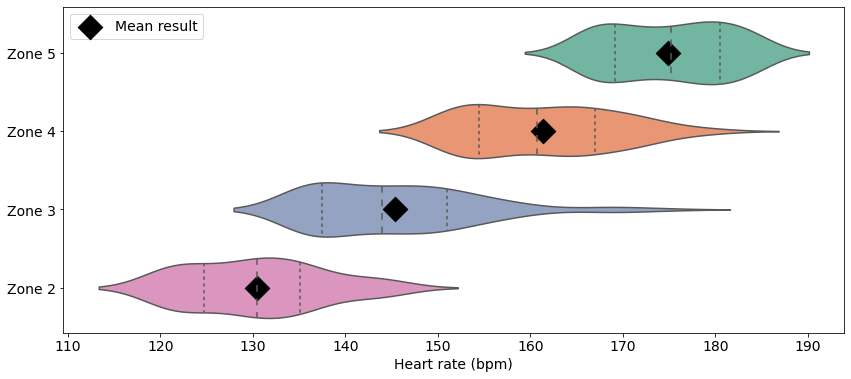

In [29]:
fig,ax = plt.subplots(1,1,figsize=(14, 6))
sns.violinplot(x = 'value', y = 'variable', inner='quartile', data = df_melt, palette="Set2", label='Heart rate zone results')
plt.scatter(x = Means, y =range(len(Means)),marker = 'D',s=300, c="k", label = 'Mean result')
plt.xlabel('Heart rate (bpm)', fontsize = 14)
plt.ylabel('', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize = 14)

There’s a larger distribution of results for lower heart rate zones. This was expected since the difference in the gradient of the cumulative fatigue versus heart rate also decreased as demonstrated in the scatter plot earlier. It was good to note that the lower quartile from each zone was always above the upper quartile of the zone below. So, this method was able to distinguish the threshold separating the heart rate zones.
We take the mean of each spread as the final zone splits.

# 5 Save results

In [25]:
power_df.to_csv('pre_processed_runnning_data.csv', index=False)
results.to_csv('final_results.csv', index=False)